In [241]:
import numpy as np 
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
from geopy.distance import geodesic

from lib.EFSpy_module import EFS
from tqdm import tqdm, trange
import copy
import time
from multitaper import MTSpec, mtspec
import struct

In [129]:
def write_spec(filepath, ehead, shead, spec, prec_wf='float32', prec_bp='int32'):
    """Reciprocal function to readspec. Writes spectrum and associated 
    information to a .spec file. Follows Peter Shearer's .spec file 
    format.

    Args:
        filepath (str): Path of the .spec file to generate
        shead (_type_): Spectral method header info dict object. Should
            contain ispec_method, ntwind, nf, twindoff, dt, and df.
        spec (_type_): _description_
        prec_wf (str, optional): _description_. Defaults to 'float32'.
        prec_bp (str, optional): _description_. Defaults to 'int32'.

    Sources:

    Last Modified:
        2023-10-30
    """

    with open(filepath, 'wb') as f:
        # Write junk and shead
        f.write(struct.pack('i', 0))  # Junk
        f.write(struct.pack('i', shead['ispec_method']))
        f.write(struct.pack('i', shead['ntwind']))
        f.write(struct.pack('i', shead['nf']))
        f.write(struct.pack('f', shead['twindoff']))
        f.write(struct.pack('f', shead['dt']))
        f.write(struct.pack('f', shead['df']))
        
        # Write junk and ehead
        f.write(struct.pack('ii', 0, 0))  # Junk
        f.write(struct.pack('40s', ehead['efslabel'].encode('UTF-8')))
        f.write(struct.pack('40s', ehead['datasource'].encode('UTF-8')))
        f.write(struct.pack('i', ehead['maxnumts']))
        f.write(struct.pack('i', ehead['numts']))
        f.write(struct.pack('i', ehead['cuspid']))
        f.write(struct.pack('4s', ehead['qtype'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmag1type'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmag2type'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmag3type'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmomenttype'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qlocqual'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qfocalqual'].encode('UTF-8')))
        f.write(struct.pack('f', ehead['qlat']))
        f.write(struct.pack('f', ehead['qlon']))
        f.write(struct.pack('f', ehead['qdep']))
        f.write(struct.pack('f', ehead['qsc']))
        f.write(struct.pack('f', ehead['qmag1']))
        f.write(struct.pack('f', ehead['qmag2']))
        f.write(struct.pack('f', ehead['qmag3']))
        f.write(struct.pack('f', ehead['qmoment']))
        f.write(struct.pack('f', ehead['qstrike']))
        f.write(struct.pack('f', ehead['qdip']))
        f.write(struct.pack('f', ehead['qrake']))
        f.write(struct.pack('i', ehead['qyr']))
        f.write(struct.pack('i', ehead['qmon']))
        f.write(struct.pack('i', ehead['qdy']))
        f.write(struct.pack('i', ehead['qhr']))
        f.write(struct.pack('i', ehead['qmn']))

        # Write 20 4-byte fields reserved for future uses
        for _ in range(20):
            f.write(struct.pack('i', 0))

        # Write time series data
        for wv in spec:
            f.write(struct.pack('ii', 3, 1))  # Junk
            f.write(struct.pack('8s', wv['stname'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['loccode'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['datasource'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['sensor'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['units'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['chnm'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['stype'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['dva'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick1q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick2q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick3q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick4q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick1name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick2name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick3name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick4name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['ppolarity'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['problem'].encode('UTF-8')))
            f.write(struct.pack('i', wv['npts']))
            f.write(struct.pack('i', wv['syr']))
            f.write(struct.pack('i', wv['smon']))
            f.write(struct.pack('i', wv['sdy']))
            f.write(struct.pack('i', wv['shr']))
            f.write(struct.pack('i', wv['smn']))
            f.write(struct.pack('f', wv['compazi']))
            f.write(struct.pack('f', wv['compang']))
            f.write(struct.pack('f', wv['gain']))
            f.write(struct.pack('f', wv['f1']))
            f.write(struct.pack('f', wv['f2']))
            f.write(struct.pack('f', wv['dt']))
            f.write(struct.pack('f', wv['ssc']))
            f.write(struct.pack('f', wv['tdif']))
            f.write(struct.pack('f', wv['slat']))
            f.write(struct.pack('f', wv['slon']))
            f.write(struct.pack('f', wv['selev']))
            f.write(struct.pack('f', wv['deldist']))
            f.write(struct.pack('f', wv['sazi']))
            f.write(struct.pack('f', wv['qazi']))
            f.write(struct.pack('f', wv['pick1']))
            f.write(struct.pack('f', wv['pick2']))
            f.write(struct.pack('f', wv['pick3']))
            f.write(struct.pack('f', wv['pick4']))

            # Write 22 4-byte fields reserved for future uses
            for _ in range(22):
                f.write(struct.pack('i', 0))

            # Write the waveform data
            np.array(wv['x1'], dtype=prec_wf).tofile(f)
            np.array(wv['x2'], dtype=prec_wf).tofile(f)
            np.array(wv['s1'], dtype=prec_wf).tofile(f)
            np.array(wv['s2'], dtype=prec_wf).tofile(f)

def load_tt(path):
    """
    Returns distance, depth, and travel time (array, array, matrix)

    Parameters
    ----------
    path : string
        path (including filename) to travel time table.

    Returns
    -------
    X : np.array
        distances.
    Y : np.array
        depths.
    T : np.array
        travel time matrix.

    """
    # these are properties of the tt tables generated by Peter Shearer's fortran codes
    n_head_lines = 3
    n_foot_lines = 1
    n_skip = n_head_lines+n_foot_lines
    
    # open file
    fp = open(path,'r')
    lines = fp.readlines()
    
    # get header lines
    head = lines[0]
    head2 = lines[1]
    
    # get dimensions of T
    nd = np.array(head2.split(),dtype=int)
    nx = nd[0]
    ny = nd[1]
    
    # init arrays
    X = np.array([],dtype=float)
    Y = np.array(lines[n_head_lines-1].split(),dtype=float)
    T = np.zeros((nx,ny),dtype=float)
    
    for ii,line in enumerate(lines[n_head_lines:]):
        ln = np.array(line.split(),dtype=float)
        X = np.append(X,ln[0])
        T[ii,:] = ln[1:]
            
    return X,Y,T

def get_pick_estimate(X, Y, TT, distance, depth, distance_units='km'):
    """Get an estimated pick time for a given event-station distance 
    and event depth using a travel time table.

    This is designed to interpolate travel times from Peter's traveltime
    codes. X, Y, and TT are np.ndarray objects output from the load_tt()
    function in stressdrop_file_IO.py. See interpolate_grid() for more 
    detailed information.

    Args:
        X (np.ndarray): Distance spacing array
        Y (np.ndarray): Depth spacing array
        TT (np.ndarray): Estimated travel times for given X and Y points
        distance (float): Event-station distance (km or degrees)
        depth (float): Event depth (km)
        distance_units (str, optional): Distance units, either 'km' or 
            'degrees'. Defaults to 'km'.

    Returns:
        Tinterp (float): Estimated travel time

    Sources:

    Last Modified:
        2024-02-06
    """

    dx = X[1] - X[0]
    dy = Y[1] - Y[0]

    if distance_units=='degrees':
        from obspy.geodetics import degrees2kilometers
        distance = degrees2kilometers(distance)
    
    try:
        # get indices of the element to the left of the value in the X and Y
        # directions. Ex: for X = [0, 1, 2, 3] and distance = 1.12, ix = 1
        ix = np.abs(X - distance).argmin()
        iy = np.abs(Y - depth).argmin()
        if distance < (ix * dx): ix -= 1
        if depth <= (iy * dy): iy -= 1

        # get left and right element relative to actual value
        xx = X[ix:ix+2]
        yy = Y[iy:iy+2]
        
        # get 4 elements surrounding actual value
        tt = TT[ix:ix+2,iy:iy+2]

        # notation: T0p: T at x[0], Yp or T(x[0], Yp)
        # Tij = T(xi, yj)
        T0p = ((tt[0,1]-tt[0,0]) / dy ) * (depth - yy[0]) + tt[0,0] #top
        T1p = ((tt[1,1]-tt[1,0]) / dy ) * (depth - yy[0]) + tt[1,0] #bottom
        Tp0 = ((tt[1,0]-tt[0,0]) / dx ) * (distance - xx[0]) + tt[0,0] #left
        Tp1 = ((tt[1,1]-tt[0,1]) / dx ) * (distance - xx[0]) + tt[0,1] #right

        # interpolate along midlines
        Tpx = ((T1p - T0p)/ dx ) * (distance - xx[0]) + T0p
        Tpy = ((Tp1 - Tp0)/ dy ) * (depth - yy[0]) + Tp0
        
        Tinterp = (Tpx+Tpy)/2
    except Exception as E:
        print(E)
        print(f"depth: {depth:.2f}")
        print(f"distance: {distance:.2f}")
        print(f"xx: {xx}")
        print(f"yy: {yy}")
        print(f"tt: {tt}")
        Tinterp = -99999.0
    return Tinterp


In [239]:
seismogram_parent_folder = "data/raw_seismograms/"
spec_dir = "data/spec_files/"

# time series parameters
window_length = 1.5
resample_rate = 100.0

# windowing options
twindoff = -0.05    # signal window offset relative to arrival time
tdif = -30.0

# spectra parameters
stn_req = 3.0


In [201]:
nt = int(window_length * resample_rate)
dt = 1 / resample_rate
df = Fn / (nf-1) # double check this
nf = int(nt/2 + 1)
Fn = resample_rate / 2

f = np.linspace(0, Fn, nf)


print("Time series and spectra info:")
print("---------------------------------------")
print(f"Sampling rate:                 {resample_rate} Hz")
print(f"Window length:                 {window_length:.2f} sec")
print(f"dt:                            {dt:.2f} sec")
print(f"Samples/window (nt):           {nt}")
print(f"Samples/frequency window (nf): {nf}")
print(f"Nyquist frequency:             {Fn:.1f} Hz")
# print(f": {:.2f}")
# print(f": {:.2f}")
# print(f": {:.2f}")
# print(f": {:.2f}")



Time series and spectra info:
---------------------------------------
Sampling rate:                 100.0 Hz
Window length:                 1.50 sec
dt:                            0.01 sec
Samples/window (nt):           150
Samples/frequency window (nf): 76
Nyquist frequency:             50.0 Hz


Load velocity model for pick estimation

In [128]:
# # shift and interpolate velocity model
# dz = 1.0
# vz = pd.read_csv('data/tt_table/vz.mammoth1', names=['z', 'vp'], sep='\\s+')
# # shift to ground level
# vz['z'] = vz['z'] - np.min(vz['z'])

# zi = np.arange(vz['z'].min(), vz['z'].max() + dz, dz)
# vpi = np.interp(zi, vz['z'], vz['vp'])

# vsi = vpi / 1.719

# with open('data/tt_table/vz.mammoth1f', 'w') as fp:
#     for i in range(len(zi)):
#         fp.write(f"{zi[i]:5.1f} {vpi[i]:4.2f} {vsi[i]:4.2f}\n")

# plt.figure()
# plt.scatter(vz['vp'], vz['z'])
# plt.plot(vpi, zi)
# plt.show()


In [134]:
X, Z, TT = load_tt('data/tt_table/out.tt')

Read previously saved event and station lists

In [92]:
inv = pd.read_csv('data/station_list.txt', keep_default_na=False)
inv['stid'] = inv['net'] + '.' + inv['sta'] + '.' + inv['loc'] + '.' + inv['cha']

cat = pd.read_csv('data/event_list.txt')

In [298]:
event_ids = [el for el in os.listdir(seismogram_parent_folder) if not el.startswith('.')]
event_ids.sort()
print(f"{len(event_ids)} events found")

completed_spec_ids = [int(el.split('.')[0]) for el in os.listdir('data/spec_files/') if el.endswith('.spec')]
if len(completed_spec_ids) > 0:
    event_ids = [el for el in event_ids if int(el) not in completed_spec_ids]
    print(f"{len(event_ids)-len(completed_spec_ids)} already completed. Skipping these.")

# required dict for write_spec()
shead = {
    'ispec_method': 11,
    'ntwind': nt,
    'nf': nt+1,
    'twindoff': twindoff,
    'dt': dt,
    'df': df
}

# loop over each folder
for i in trange(len(event_ids), desc='Computing spectra: '):
    event_id = int(event_ids[i])

    # print(event_id)
    # load miniseeds
    seis_path = seismogram_parent_folder + str(event_id) + "/"
    seis_files = [el for el in os.listdir(seis_path) if el.endswith('.mseed')]
    if len(seis_files) > 0:
        st = obspy.core.stream.read(seis_path + "*.mseed", format="MSEED")
        # print(f"   {len(st)} traces in event")

        # find the event_id in cat object to get information
        ev = cat.iloc[np.where(cat['event_id'].values==int(event_id))[0][0]]

        # Some depths are negative (due to topography?). Toss these.
        if ev['qdep'] > 0:
            # split origin time string
            tA, tB = ev.origin_time.split(' ')
            ymd = tA.split('-')
            hms = tB.split(':')

            ehead = {
                'efslabel': '',
                'datasource': '',
                'maxnumts': len(st),
                'cuspid': int(event_id),
                'qtype': '',
                'qmag1type': ev['qmagtype'],
                'qmag2type': '',
                'qmag3type': '',
                'qmomenttype': '',
                'qlocqual': '',
                'qfocalqual': '',
                'qlat': ev['qlat'],
                'qlon': ev['qlon'],
                'qdep': ev['qdep'],
                'qsc': float(hms[2]),
                'qmag1': ev['qmag'],
                'qmag2': 0.0,
                'qmag3': 0.0,
                'qmoment': 0.0,
                'qstrike': 0.0,
                'qdip': 0.0,
                'qrake': 0.0,
                'qyr':  int(ymd[0]),
                'qmon': int(ymd[1]),
                'qdy':  int(ymd[2]),
                'qhr':  int(hms[0]),
                'qmn':  int(hms[1]),
                'numts': 0
            }
            
            # spec is a list of dicts
            spec = []
            for j, tr in enumerate(st):
                len_tr_init = len(tr)

                # calculate station-event distances
                sta = inv.iloc[np.where(inv['stid']==tr.id)[0][0]]
                deldist = geodesic((ev['qlat'], ev['qlon']), (sta['slat'], sta['slon'])).km


                # estimate travel time
                tpick = get_pick_estimate(X, Z, TT, deldist, ev['qdep'], distance_units='km')

                # store initial time series, relative to origin time
                t_init = tr.times() + tdif
                x_init = tr.data

                # is this correct?
                t_arrival = tr.stats.starttime - tdif + tpick

                # if trace's sample rate is close to the desired rate, select window
                # directly
                if np.isclose(tr.stats.sampling_rate, resample_rate):
                    # UTCDateTime exact time of estimated arrival
                    tr.trim(starttime=t_arrival - (window_length + abs(twindoff)) + dt,
                            endtime=t_arrival + (window_length - abs(twindoff)))
                else:
                    # do a rough window to speed up resample()
                    tr.trim(starttime=t_arrival - (window_length + abs(twindoff)),
                            endtime=t_arrival + (window_length + abs(twindoff)))

                    # resample, then trim to exact size
                    tr.resample(resample_rate)
                    tr.trim(starttime=t_arrival - (window_length + abs(twindoff)) + dt,
                            endtime=t_arrival + (window_length - abs(twindoff)))


                tr.detrend(type='demean')

                x1 = tr.data[:nt]
                x2 = tr.data[nt:]

                t = tr.times() - window_length

                # check the signal to noise ratio. np.diff stabilizes low frequency trends
                if np.median(np.abs(np.diff(x2))) / np.median(np.abs(np.diff(x1))) >= stn_req:

                    title = " | ".join([str(ev['event_id']), sta['stid'], f"dist: {deldist:.2f} km", f"{deldist/tpick:.2f}km/s"])
                    # plt.figure(figsize=(10,5))
                    # plt.plot(t_init, x_init, linewidth=0.5, c='k')
                    # plt.plot(t, tr.data, c='r')
                    # plt.axvline(0, c='k')
                    # plt.axvline(tpick, c='r', linestyle='--', label='P-wave pick')
                    # plt.title(title)
                    
                    # plt.legend(loc='lower left')
                    # plt.show()

                    S1 = MTSpec(x1)
                    S2 = MTSpec(x2)
                    f1, s1 = S1.rspec()
                    f2, s2 = S2.rspec()

                    f1 = f1.flatten()
                    f2 = f2.flatten()
                    s1 = s1.flatten()
                    s2 = s2.flatten()

                    # not 'correct', but suppresses errors
                    f1[0] = f1[1] / 2
                    f2[0] = f2[1] / 2

                    # correct to displacement
                    if sta['units'].lower()=='m/s':
                        s1 = s1 / (2 * np.pi * f1)
                        s2 = s2 / (2 * np.pi * f2)
                        s1[0] = s1[1]
                        s2[0] = s2[1]
                    elif sta['units'].lower()=='m/s**2':
                        s1 = s1 / ((2 * np.pi * f1)**2)
                        s2 = s2 / ((2 * np.pi * f2)**2)
                        s1[0] = s1[1]
                        s2[0] = s2[1]

                    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
                    # ax1.plot(t, tr.data, linewidth=0.5, c='k')
                    # ax1.axvline(0, c='k')

                    # ax2.plot(f1, s1, c='k', linestyle='--')
                    # ax2.plot(f2, s2, c='k')
                    # ax2.set_xscale('log')
                    # ax2.set_yscale('log')

                    # write to .spec files
                    sp = {
                        'stname': sta['sta'],
                        'loccode': sta['loc'],
                        'datasource': '',
                        'sensor': '',
                        'units': sta['units'], 
                        'chnm': sta['cha'],
                        'stype': sta['net'],
                        'dva': '',
                        'pick1q': '',
                        'pick2q': '',
                        'pick3q': '',
                        'pick4q': '',
                        'pick1name': '',
                        'pick2name': '',
                        'pick3name': '',
                        'pick4name': '',
                        'ppolarity': '',
                        'problem': '',
                        'npts': len_tr_init,
                        'syr': 0,
                        'smon': 0,
                        'sdy': 0,
                        'shr': 0,
                        'smn': 0,
                        'compazi': -99.0,
                        'compang': -99.0,
                        'gain': 1.0,
                        'f1': -1.0,
                        'f2': -1.0,
                        'dt': resample_rate,
                        'ssc': 0,
                        'tdif': tdif,
                        'slat': sta['slat'],
                        'slon': sta['slon'],
                        'selev': sta['sele'],
                        'deldist': deldist,
                        'sazi': 0,
                        'qazi': 0,
                        'pick1': tpick,
                        'pick2': 0.0,
                        'pick3': 0.0,
                        'pick4': -99.0,
                        'x1': x1,
                        'x2': x2,
                        's1': s1,
                        's2': s2
                    }

                    spec.append(sp)
            ehead['numts'] = len(spec)
            # print(len(spec))
            if len(spec) >= 3:
                write_spec(spec_dir+str(event_id)+".spec", ehead, shead, spec)

4893 events found
2083 already completed. Skipping these.


Computing spectra:   2%|▏         | 54/3488 [00:08<08:23,  6.82it/s]/Users/ivandevert/miniconda3/envs/specdecomp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivandevert/miniconda3/envs/specdecomp/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Computing spectra:   3%|▎         | 104/3488 [00:15<07:54,  7.13it/s]/var/folders/n9/y3b20y1x2dx7n3qq1qn2cn2m000jzz/T/ipykernel_89086/1748772612.py:116: RuntimeWarning: invalid value encountered in scalar divide
  if np.median(np.abs(np.diff(x2))) / np.median(np.abs(np.diff(x1))) >= stn_req:
Computing spectra:  43%|████▎     | 1507/3488 [03:01<06:20,  5.20it/s]/var/folders/n9/y3b20y1x2dx7n3qq1qn2cn2m000jzz/T/ipykernel_89086/1748772612.py:116: RuntimeWarning: divide by zero encountered in scalar divide
  if np.median(np.abs(np.diff(x2)

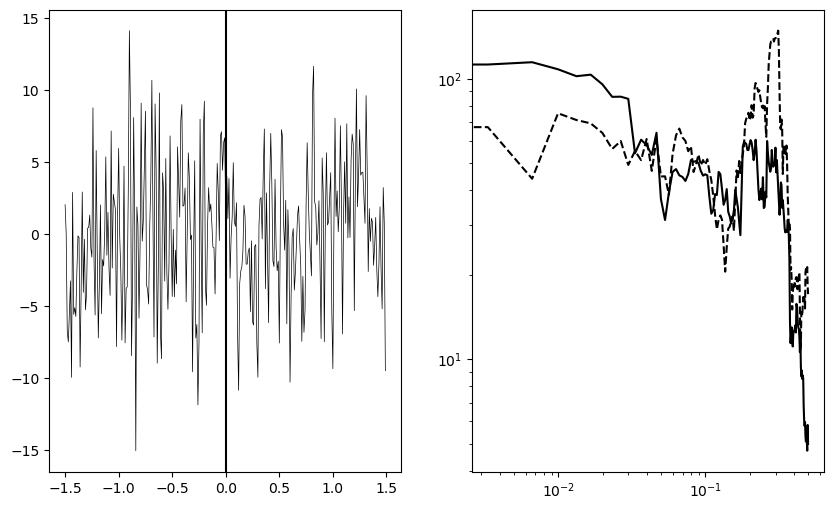

In [237]:

S1 = MTSpec(x1)
S2 = MTSpec(x2)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
ax1.plot(t, tr.data, linewidth=0.5, c='k')
ax1.axvline(0, c='k')
f1, s1 = S1.rspec()
f2, s2 = S2.rspec()
# ax2.plot(f, s1.rspec(), c='k', linestyle='--')
ax2.plot(f1, s1, c='k', linestyle='--')
ax2.plot(f2, s2, c='k')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.show()